In [25]:
ROOT_FOLDER = '/root/jupyter_home/keras_Object_Detection'

In [2]:
cd $ROOT_FOLDER

/root/jupyter_home/keras_Object_Detection


In [3]:
!cp /root/jupyter_home/YOLO_Object_Detection/Fire/fire-dataset.zip .

In [ ]:
!unzip fire-dataset.zip

In [5]:
!mkdir $ROOT_FOLDER/Firedevkit
!mkdir $ROOT_FOLDER/Firedevkit/Fire
!mkdir $ROOT_FOLDER/Firedevkit/Fire/Annotations
!mkdir $ROOT_FOLDER/Firedevkit/Fire/ImageSets
!mkdir $ROOT_FOLDER/Firedevkit/Fire/ImageSets/Main
!mkdir $ROOT_FOLDER/Firedevkit/Fire/JPEGImages

In [6]:
cd $ROOT_FOLDER/Firedevkit/Fire/Annotations

/root/jupyter_home/keras_Object_Detection/Firedevkit/Fire/Annotations


In [7]:
!cp -r $ROOT_FOLDER/fire-dataset/train/annotations/*.xml .
!cp -r $ROOT_FOLDER/fire-dataset/validation/annotations/*.xml .

In [8]:
cd $ROOT_FOLDER/fire-dataset

/root/jupyter_home/keras_Object_Detection/fire-dataset


In [9]:
import os

folder_path = './train/images'
output_file = 'fire_train.txt'

with open(output_file, 'w') as f:
    for filename in os.listdir(folder_path):
        name, _ = os.path.splitext(filename)
        f.write(name + '\n')

folder_path = './validation/images'
output_file = 'fire_val.txt'

with open(output_file, 'w') as f:
    for filename in os.listdir(folder_path):
        name, _ = os.path.splitext(filename)
        f.write(name + '\n')

In [10]:
cd $ROOT_FOLDER/Firedevkit/Fire/ImageSets/Main

/root/jupyter_home/keras_Object_Detection/Firedevkit/Fire/ImageSets/Main


In [11]:
!cp $ROOT_FOLDER/fire-dataset/fire_train.txt .
!cp $ROOT_FOLDER/fire-dataset/fire_val.txt .

In [12]:
cd $ROOT_FOLDER/Firedevkit/Fire/JPEGImages

/root/jupyter_home/keras_Object_Detection/Firedevkit/Fire/JPEGImages


In [13]:
!cp -r $ROOT_FOLDER/fire-dataset/train/images/*.jpg .
!cp -r $ROOT_FOLDER/fire-dataset/validation/images/*.jpg .

In [14]:
# Pascal FIRE Dataset을 TFRecord로 변환하는 코드
import os
import tensorflow as tf
import xml.etree.ElementTree as ET

# FIRE 클래스 목록 (20 classes)
FIRE_CLASSES = [
    "fire"
]
class_name_to_id = {name: i for i, name in enumerate(FIRE_CLASSES)}

def parse_fire_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename = root.find("filename").text
    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)

    bboxes = []
    labels = []

    for obj in root.findall("object"):
        name = obj.find("name").text
        label = class_name_to_id[name]

        bbox = obj.find("bndbox")
        xmin = int(float(bbox.find("xmin").text))
        ymin = int(float(bbox.find("ymin").text))
        xmax = int(float(bbox.find("xmax").text))
        ymax = int(float(bbox.find("ymax").text))

        bboxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)

    return filename, width, height, bboxes, labels

def create_tf_example(image_path, xml_path):
    filename, width, height, bboxes, labels = parse_fire_xml(xml_path)

    with tf.io.gfile.GFile(image_path, 'rb') as fid:
        encoded_image = fid.read()

    xmins = [box[0] / width for box in bboxes]
    ymins = [box[1] / height for box in bboxes]
    xmaxs = [box[2] / width for box in bboxes]
    ymaxs = [box[3] / height for box in bboxes]

    classes_text = [FIRE_CLASSES[label].encode('utf8') for label in labels]
    classes = labels

    feature = {
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_image])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode('utf8')])),
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
    }

    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example

def generate_tfrecord(fire_dir, split_txt, output_path):
    annotation_dir = os.path.join(fire_dir, 'Annotations')
    image_dir = os.path.join(fire_dir, 'JPEGImages')

    with tf.io.TFRecordWriter(output_path) as writer:
        with open(split_txt, 'r') as f:
            lines = f.read().strip().splitlines()

        for img_id in lines:
            xml_path = os.path.join(annotation_dir, f"{img_id}.xml")
            img_path = os.path.join(image_dir, f"{img_id}.jpg")

            if os.path.exists(xml_path) and os.path.exists(img_path):
                example = create_tf_example(img_path, xml_path)
                writer.write(example.SerializeToString())

FIRE_ROOT_DIR = '/root/jupyter_home/keras_Object_Detection'

# 실행
generate_tfrecord(
    fire_dir=FIRE_ROOT_DIR + "/Firedevkit/Fire",
    split_txt=FIRE_ROOT_DIR + "/Firedevkit/Fire/ImageSets/Main/fire_train.txt",
    output_path=FIRE_ROOT_DIR + "/fire_train.tfrecord"
)

generate_tfrecord(
    fire_dir=FIRE_ROOT_DIR + "/Firedevkit/Fire",
    split_txt=FIRE_ROOT_DIR + "/Firedevkit/Fire/ImageSets/Main/fire_val.txt",
    output_path=FIRE_ROOT_DIR + "/fire_val.tfrecord"
)

In [26]:
cd $ROOT_FOLDER

/root/jupyter_home/keras_Object_Detection


In [27]:
# 만들어진 TFRecord를 이용해서 tf.data.Dataset을 생성하는 코드
import tensorflow as tf

IMAGE_SIZE = 512

def parse_tfrecord(example):
    features = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }

    parsed = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(parsed['image/encoded'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])

    xmins = tf.sparse.to_dense(parsed['image/object/bbox/xmin'])
    ymins = tf.sparse.to_dense(parsed['image/object/bbox/ymin'])
    xmaxs = tf.sparse.to_dense(parsed['image/object/bbox/xmax'])
    ymaxs = tf.sparse.to_dense(parsed['image/object/bbox/ymax'])
    labels = tf.sparse.to_dense(parsed['image/object/class/label'])

    boxes = tf.stack([xmins, ymins, xmaxs, ymaxs], axis=-1)

    return {
        "images": image,
        "bounding_boxes": {
            "boxes": boxes,
            "classes": tf.cast(labels, tf.int32),
        }
    }

def load_dataset(tfrecord_path, batch_size=8):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord, 
                          num_parallel_calls=tf.data.AUTOTUNE)
    
    # padded_batch 필수
    dataset = dataset.shuffle(1000).padded_batch(
        batch_size,
        padded_shapes={
            "images": [IMAGE_SIZE, IMAGE_SIZE, 3],
            "bounding_boxes": {
                "boxes": [None, 4],
                "classes": [None]
            }
        },
        drop_remainder=True
    ).prefetch(tf.data.AUTOTUNE)

    return dataset


train_ds = load_dataset("./fire_train.tfrecord", 
                        batch_size=8)

val_ds = load_dataset("./fire_val.tfrecord", 
                        batch_size=8)     

In [28]:
# Model 생성
from keras_cv.models import RetinaNet

model = RetinaNet.from_preset(
    'resnet50',
    bounding_box_format='xyxy',
    num_classes=1
)

In [29]:
# Model compile
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-4),
              classification_loss='focal',
              box_loss='smoothl1')

In [ ]:
# 모델 재학습
model.fit(train_ds,
          epochs=100,
          verbose=1)
# Epoch 100/100
# 51/51 [==============================] - 19s 378ms/step - 
# loss: 0.0000e+00 - box_loss: 0.0000e+00 - classification_loss: 0.0000e+00 - 
# percent_boxes_matched_with_anchor: 0.5356

1/1 [==============================] - 5s 5s/step


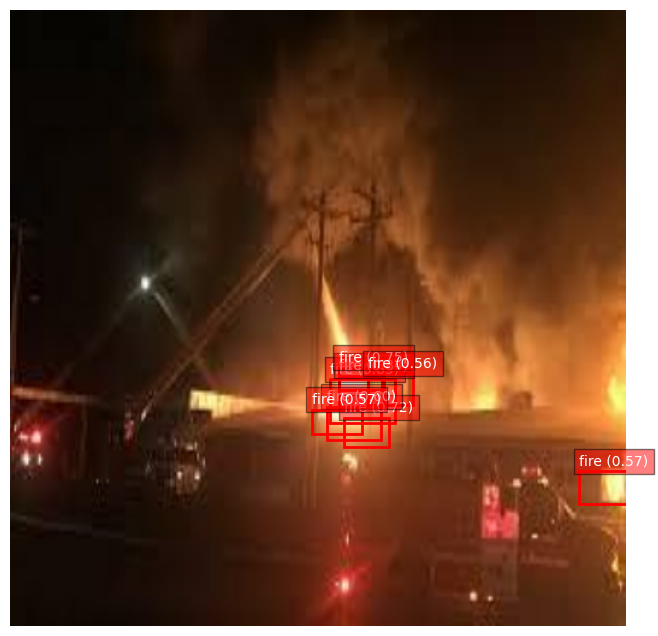

In [33]:
# 예측 및 시각화
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

FIRE_CLASSES = [
    "fire"
]

def visualize_prediction(image, boxes, classes, scores, threshold=0.3):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    for box, cls, score in zip(boxes, classes, scores):
        if score < threshold:
            continue
        
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle(
            (x1, y1), w, h,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        class_name = FIRE_CLASSES[int(cls)]
        ax.text(
            x1, y1 - 5,
            f"{class_name} ({score:.2f})",
            fontsize=10,
            color="white",
            bbox=dict(facecolor="red", alpha=0.5)
        )

    plt.axis("off")
    plt.show()

# 예측 결과 (batched)
sample = next(iter(val_ds))
images, y_true = sample["images"], sample["bounding_boxes"]

# 예측 (batched)
y_pred = model.predict(images)

# 첫 번째 이미지만 시각화
image = images[0].numpy()
# 이미지 크기에 맞게 scale (RetinaNet은 512x512로 resize됨)
image = np.clip(image * 255, 0, 255).astype("uint8")

boxes = y_pred["boxes"][0]
classes = y_pred["classes"][0]
scores = y_pred["confidence"][0]

visualize_prediction(image, boxes, classes, scores, threshold=0.3)